# Tutorial: Inversion config setup

This jupyter notebook goes through the various different parameters that can be set in the inversion_config.yml file and aims to help you setup your own inversion. As an example we aim to perform an inversion for yesterday's ambient noise data for 6 stations in Switzerland. 

The parameters can also be set directly in the inversion_config.yml for your own applications. Make sure to change the relevant paths and re-compute the wavefields. 

In [1]:
# import packages
import os
import numpy as np
import yaml 
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.tri as tri
from matplotlib import colors
from pandas import read_csv

from noisi.util.geo import is_land, geographical_distances
from noisi.scripts.source_grid import create_sourcegrid

import pprint

pp = pprint.PrettyPrinter(sort_dicts=False)

# setup dictionary
inv_config = dict()

### Project setup

First we want to give the project a name and provide a folder where the inversion will be saved. Additional parameters are explained below. 

In [2]:
main = {
    # output folder is where the inversion will be saved, path will be created if it does not exist
    'output_folder': './noisi_output',
    
    # path to a stationlist which will be used for the inversion
    # should contain "net, sta, lat, lon" in a csv file
    # can be left empty if a region is set in the data download parameter
    #'stationlist': None,
    'stationlist': os.path.abspath('./noisi/examples_inv/stationlist_swiss_6.csv'),
    
    # metadata can be added to the synthetic correlations
    # useful when synthetic data is computed and then used for synthetic inversions
    'add_metadata': False,
    
    # random noise to be added to the synthetic correlations
    # value is the amplitude of the random noise, usually around 1.5 for real data
    'add_noise': 1.5,
    
    # set to true if output should be plotted
    'output_plot': True
}

#pp.pprint(main)

In [3]:
project_config = {
    # Project name
    'project_name': 'noisi_inv_example',
    
    # type of seismic data (DIS, VEL, ACC). Usually DIS for our inversions. 
    'synt_data': 'DIS',
    
    # set verbose to true if you want more printed output
    'verbose': False,
    
    # loading wavefield to memory increases computationally speed (True) 
    'load_to_memory': True,
    
    # output files can be compressed (True), .sac and .npy will be converted to hdf5 files
    # set to 'delete' if those files should be deleted after the inversion
    # set to False to keep all files
    'compress_output_files': False
}

#pp.pprint(project_config)

### Data download

These parameters need to be set if you want to automatically download, process, and cross-correlate data. 
If a stationlist is provided the min_station_dist, domain_type and following parameters can be ignored.
If no stationlist is given a domain_type and can be given and all available data will be downloaded. 

In [4]:
data_download = {
    
    # set to true if you want to download data
    'download_data': True,
    
    # set a data to download data for
    # can be set to yesterday or a date, e.g. "2021-03-30"
    'download_data_date': 'yesterday',
    
    # number of days you want to download data for
    'download_data_days': 1,
    
    # which channels do you want to download data for?
    # we focus on vertical component measurements on broadband seismometers, so BHZ
    'download_data_channels': ['BHZ'],
    
    # window length that the data will split up into and processed, in seconds
    'process_data_win_len': 7200,
    
    # overlap of those windows, in seconds
    'process_data_overlap': 100,

    # set to true if you want to exclude windows which have earthquakes from the GCMT catalogue
    'gcmt_exclude': True,

    # If no stationlist is given you can provide a minimum station distance in degrees
    # 1 degree is roughly 111km 
    'min_station_dist': 0,
    
    # domain type for the obspy mass downloader
    # see: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html
    # Possible values: circular, rectangular, global
    'domain_type': 'circular',

    # if domain_type is circular: provide lat,lon of the centre of the circle
    # and the minimum and maximum radius in degrees
    'circ_lat_center': 46,
    'circ_lon_center': 8,
    'circ_radius_min': 5,
    'circ_radius_max': 45,

    # if domain_type is rectangular: provide min/max lat/lon for the rectangle
    'rect_lat_min': 30,
    'rect_lat_max': 70,
    'rect_lon_min': -30,
    'rect_lon_max': 40
}

#pp.pprint(data_download)

### Plotting the domain

We quickly visualise the domain where data will be downloaded.
Unless a stationlist is given, then we plot the stationlist. 

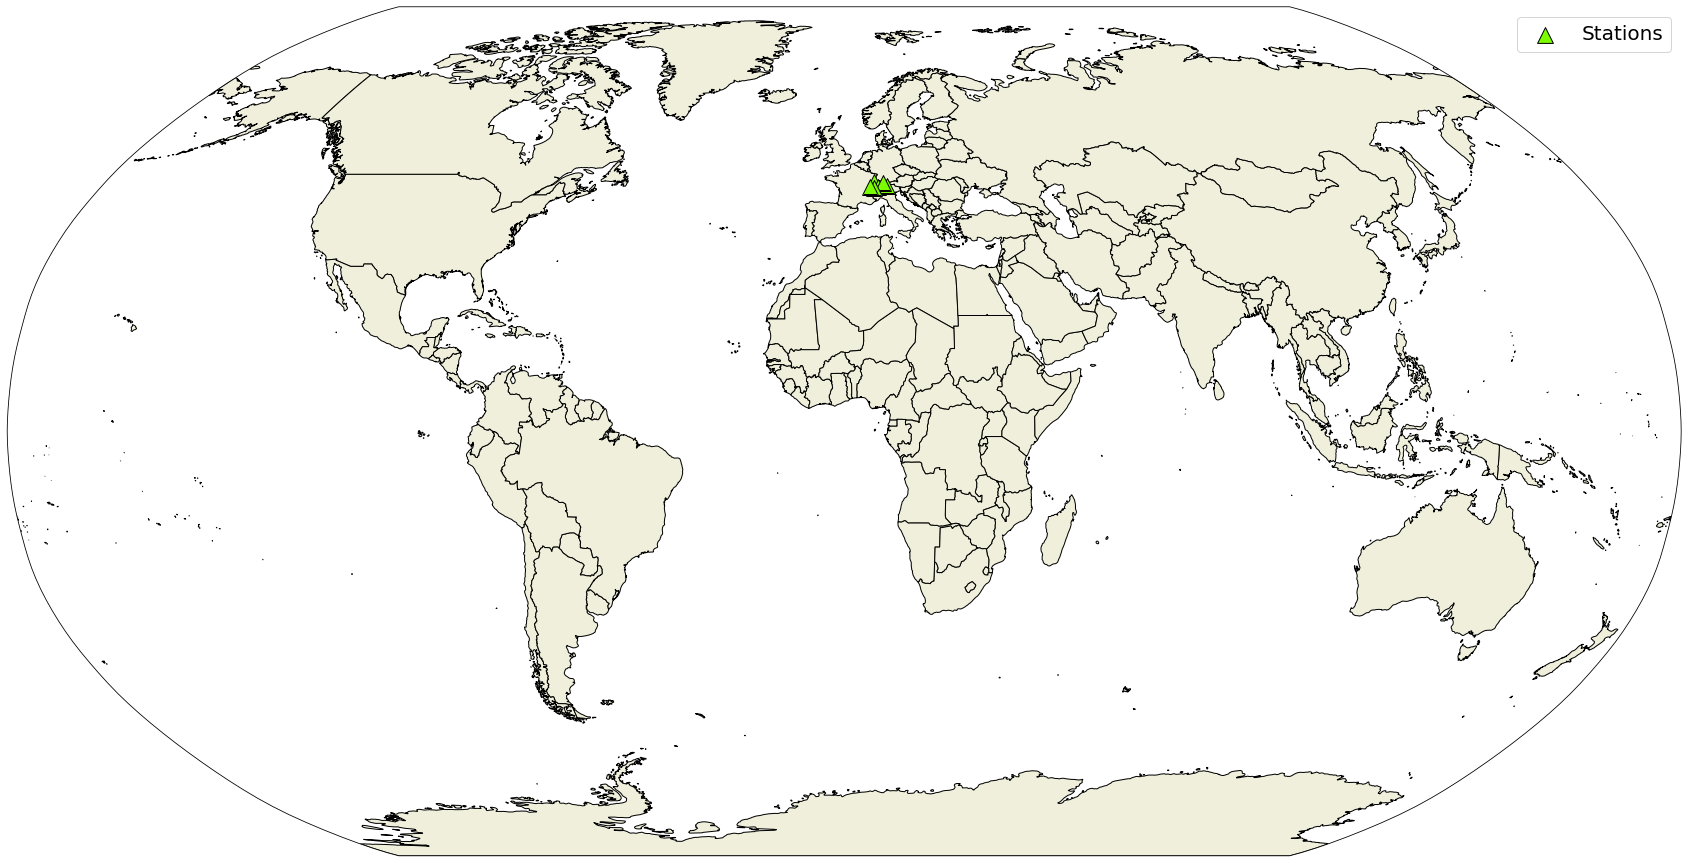

In [5]:
# if stationlist exists, plot stations
# else plot the domain
if main['stationlist'] != None and os.path.isfile(main['stationlist']):
    stationlist = read_csv(main['stationlist'],keep_default_na=False)
    
    lat,lon = stationlist['lat'],stationlist['lon']

    plt.figure(figsize=(30,30))
    ax = plt.axes(projection=ccrs.Robinson())
    plt.scatter(lon,lat,s=250,c='lawngreen',marker='^',edgecolor='k',linewidth=1,transform=ccrs.PlateCarree(),zorder=4, label='Stations')
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m', edgecolor='black', facecolor=cfeature.COLORS['land']),zorder=2)
    ax.set_global()
    plt.legend(fontsize=20)
    plt.show()
    

else:
    stationlist = False
    
    plt.figure(figsize=(30,30))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m', edgecolor='black', facecolor=cfeature.COLORS['land']),zorder=2)
    ax.set_global()
    
    # circular domain
    if data_download['domain_type'] == 'circular':
        ax.add_patch(mpatches.Circle(xy=[data_download['circ_lon_center'], data_download['circ_lat_center']], radius=data_download['circ_radius_min'], color='k', alpha=0.3, transform=ccrs.PlateCarree(), zorder=30))
        ax.add_patch(mpatches.Circle(xy=[data_download['circ_lon_center'], data_download['circ_lat_center']], radius=data_download['circ_radius_max'], color='b', alpha=0.2, transform=ccrs.PlateCarree(), zorder=31))

    elif data_download['domain_type'] == 'rectangular':
        lon_width = data_download['rect_lon_max']-data_download['rect_lon_min']
        lat_height = data_download['rect_lat_max']-data_download['rect_lat_min']
        
        ax.add_patch(mpatches.Rectangle(xy=[data_download['rect_lon_min'], data_download['rect_lat_min']], width=lon_width, height=lat_height, facecolor='b',alpha=0.3,transform=ccrs.PlateCarree(),zorder=32))

    
    elif data_download['domain_type'] == 'global':
        pass
    
    else:
        print("Check your domain_type parameter. Should be one of: circular, rectangular, global.")
    
    plt.title(f"Domain: {data_download['domain_type']}",pad=15,fontsize=40)
    plt.show()
    

### Inversion parameters

We now set some of the parameters for the inversion. 

In [6]:
inversion_config = {
    
    # If you already have cross-correlations you can set the path here
    # if you are downloading data using the previously set parameters, set it to None
    'observed_corr': None,
    
    # If you have a list of stationpairs as csv file (format: NET.STA.LOC.CHA--NET.STA.LOC.CHA)
    # you can provide this here and only those stationpairs will be used
    'opt_statpair': None,
    
    # The snr_thresh (signal-to-noise ratio threshold) sets a lower limit for correlations
    # all correlations with a higher snr will be copied and used for the inversion
    'snr_thresh': 3,
    
    # set a maximum distance for station pairs
    'corr_max_dist': None,
    
    # Number of iterations for the inversion
    'nr_iterations': 5,
    
    # Number of step tests in each iteration
    'nr_step_tests': 5,
    
    # If this is set to True it tests different smoothing paramaters during the step length test
    # if the step tests do not decrease the misfit
    'step_test_smoothing': False,
    
    # what fraction of the correlations should be used for the step length test
    # 1 means all, 2 means half etc. 
    'frac_corr_slt': 1,
    
    # set the minimum step length for the test
    'step_length_min': 0.05,
    
    # set the maximum step length for the test
    'step_length_max': 3.0,
    
    # set the smoothing (in degrees) for iterations
    # given by a list of lists with [[iteration,smoothing],[iteration,smoothing]...]
    # Example: [[2,4],[5,2],[7,1]]. Up to iteration 2 smoothing will be 4 degrees, from 3 to 5 it will be 2 degrees, from 5 to 7 it will be 1 degree
    # any higher iterations will use the last given value
    'step_smooth': [[2,3],[4,2],[6,1.5],[8,1]],
    
    # Smoothing parameter: At what percentage should the data be capped? 
    'smoothing_cap': 95
}

#pp.pprint(inversion_config)

### Setup sourcegrid

The next step is to create a sourcegrid. There are a few options on how to do that but for these inversions we recommend using the spatially variable grids (svp). 

In [7]:
# Spatially Variable Grid (SVP) 

svp_grid_config = {
    
    # set to true if you want to use a spatially variable grid
    ##### RECOMMENDED TO TRUE FOR INVERSIONS #####
    'svp_grid': True,
    
    # set to True if the svp should be 'flipped' at the equator to be equal on both hemispheres before rotating
    'svp_dense_antipole': False,
    
    # set to True if the grid should only be in the ocean
    'svp_only_ocean': True,
    
    # set to True if voronoi surface areas should be used
    'svp_voronoi_area': True,
    
    # Remove station pairs in a radius (degrees) around the stations
    'svp_station_remove': 1,
    
    # Should the grid be plotted?
    'svp_plot': False,
    
    # Beta describes the stepness of the grid point distance increase
    'svp_beta': [7],
    
    # Gamma is used when multiple dense grids want to be implemented
    # It dictates the radius where the underlying grid will be replaced with a denser grid
    # Only in use if more than one value is given in the other parameters
    'svp_gamma': [0],
    
    # Centre of the grid
    'svp_lat_0': [47],
    'svp_lon_0': [8],
    
    # Minimum grid point distance in degrees
    'svp_phi_min': [1],
    
    # Maximum grid point distance in degrees
    'svp_phi_max': [5],
    
    # Radius around the centre of the grid where minimum grid point distance is constant
    'svp_sigma': [10]
}

In [8]:
# Normal grid, used if svp_grid and auto_data_grid are set to False
# NOT RECOMMENDED FOR INVERSION

grid_config = {
    
    # grid point distance in metres
    'grid_dx_in_m': 35000,
    
    # set the domain of the grid
    'grid_lat_max': 65,
    'grid_lat_min': 30,
    'grid_lon_max': 25,
    'grid_lon_min': -15
}

In [9]:
# Automatic grid based on data
# NOT RECOMMENDED FOR INVERSION
# USEFUL FOR FORWARD MODELLING OF CORRELATIONS

auto_data_grid_config = {
    
    # Set to true if automatic grid is wanted
    # NOT RECOMMENDED
    'auto_data_grid': False,
    
    #  Path to the data that the grid should be based on
    'auto_data_path': None,
    
    # Threshold between 0 and 1 above which a denser grid will be added (for normalised data)
    'auto_data_thresh': 0.5,
    
    # Radius (degrees) around stations that should be removed from the grid
    'auto_station_remove': 1,
    
    # Set the centre of the background grid automatically
    # One of 'data', 'stations', [longitude, latitude]
    'auto_back_grid_centre': 'stations',
    
    # Minimum grid point distance (degrees) for background grid
    'auto_back_grid_phi_min': 2,
    
    # Maximum grid point distance (degrees) for background grid
    'auto_back_grid_phi_max': 4,
    
    # Grid point distance (degrees) for additional grids
    'auto_data_grid_phi': 1,
    
    # [lon_min,lon_max,lat_min,lat_max] gives area in which grid will be made denser
    'auto_extent': [-90,0,0,90],
    
    # radius (degrees) in which old grid will be replaced with new grid
    'auto_gamma_thresh': 5
}

### Plot spatially variable grid

Number of grids:  1
Removing gridpoints in 1 radius of stations..
Number of gridpoints:  5183


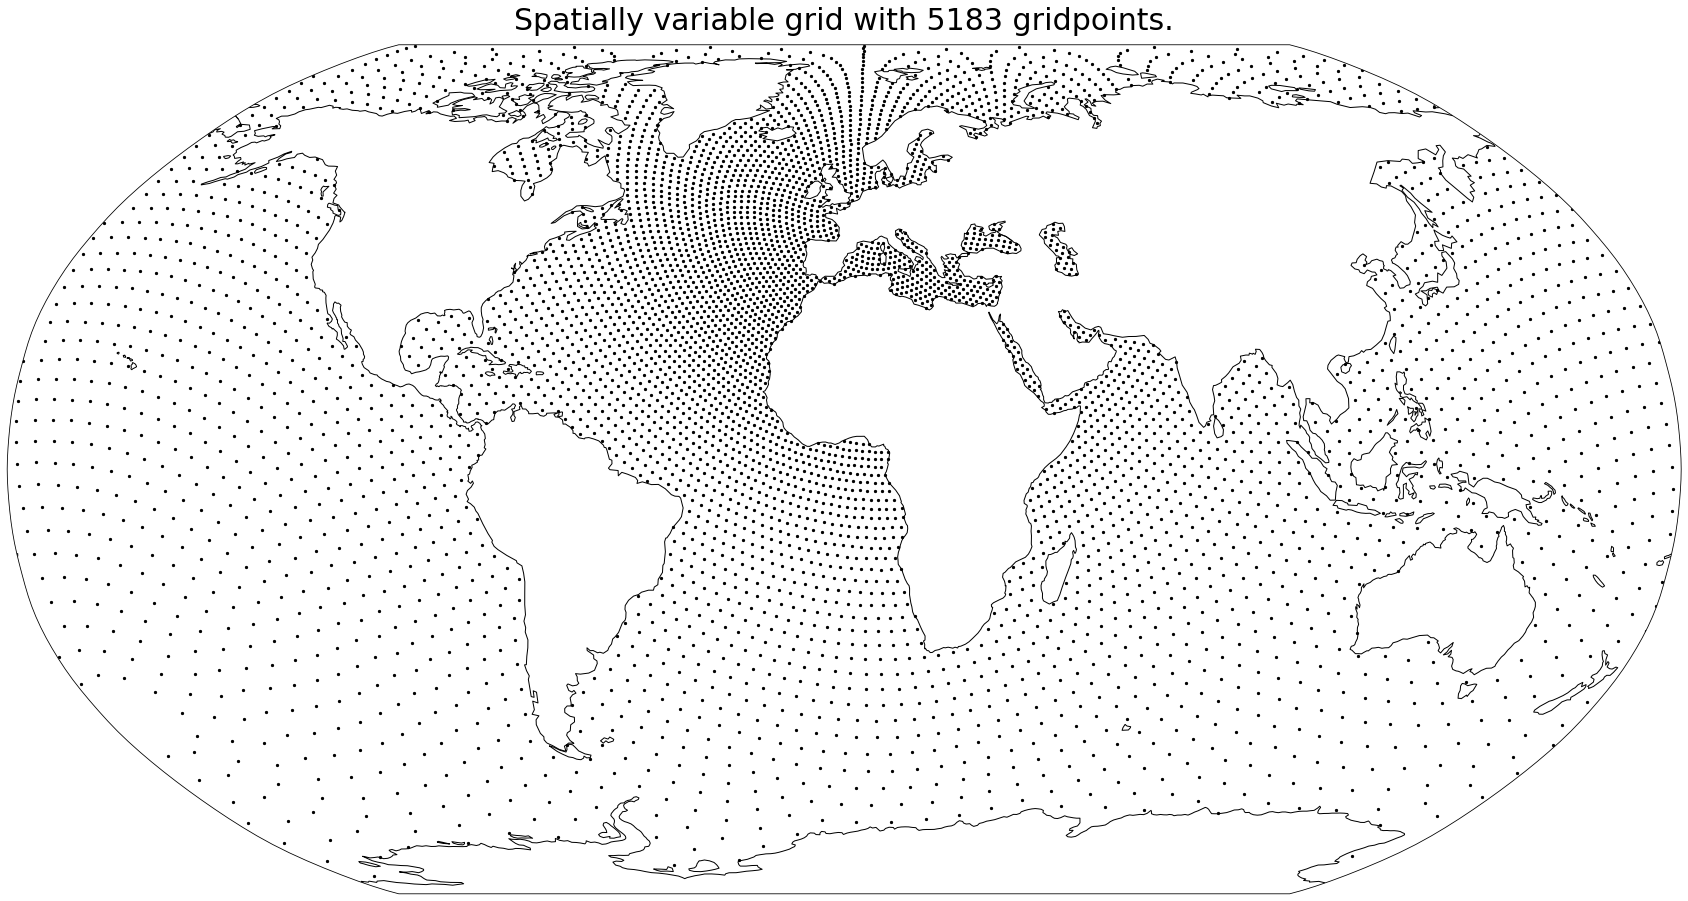

In [10]:
# dictionary to check grid
grid_dict = dict()

# add parameters
grid_dict.update(auto_data_grid_config)
grid_dict.update(svp_grid_config)
grid_dict.update(grid_config)
grid_dict.update(main)
grid_dict.update(project_config)

# set to false to check the grid
grid_dict['svp_voronoi_area'] = False

sourcegrid = create_sourcegrid(grid_dict,stationlist_path=main['stationlist'])

plt.figure(figsize=(30,30))
ax = plt.axes(projection=ccrs.Robinson())
plt.scatter(sourcegrid[0],sourcegrid[1],s=5,c='k',transform=ccrs.PlateCarree(),zorder=4)
ax.coastlines(color='white',linewidth=3)
ax.coastlines(color='black',linewidth=1)
ax.set_global()
plt.title(f"Spatially variable grid with {np.size(sourcegrid[0])} gridpoints.",fontsize=30,pad=15)
plt.show()


### Wavefield parameters

To model the cross-correlations we need to set wavefield parameters

In [11]:
wavefield_config = {
    
    # channels can be either a list or a string of E, N, Z
    # We focus on the vertical component
    'wavefield_channel': 'Z',
    
    # wavefield domain either time or fourier, default to time
    'wavefield_domain': 'time',
    
    # duration of the wavefield
    'wavefield_duration': 5000.0,
    
    # wavefield bandpass filter can be set here
    'wavefield_filter': None,
    
    # Wavefield path to a pre-computed wavefield like AxiSEM/SpecFEM 
    # or a folder with already converted Green's functions
    # AxiSEM wavefields can be downloaded from Syngine: http://ds.iris.edu/ds/products/syngine/
    'wavefield_path': '/Users/jigel/noisi/wavefields/Noisi_10s_repacked/', 
    
    # Wavefield type, set to 'greens' if a folder to already converted Green's functions is given
    # or to 'instaseis' if path to wavefield is given
    # or 'analytic' 
    # We use analytic to save computational cost, not very realistic for larger inversions
    'wavefield_type': 'analytic',
    
    # Point force of each model source
    'wavefield_point_force': 1.0e9,
    
    # Sampling rate of the data
    'wavefield_sampling_rate': 1.0,
    
    # Set parameters if wavefield type is analytic
    'v': 3000.0,
    'q': 100.0,
    'rho': 3000.0
}

### Source parameters

In [12]:
source_config = {
    
    # set to True if auto correlation should also be computed
    'get_auto_corr': False,
    
    # set to True if only the observed correlations should be modelled
    'model_observed_only': True,
    
    # set the maximum lag (in seconds) of the correlations
    'max_lag': 1500,
    
    # should diagonals be used? (False for vertical components)
    'diagonals': False,
    
    # set to True of horizontal components should be rotated
    'rotate_horizontal_components': False
}

### Source setup: initial model

We now set the initial model for the inversion. This can be a homogeneous distribution everywhere, in the ocean, a distribution with gaussian blobs, or created using the Matched-Field Processing method. 

In [13]:
# list of initial model
# for the inversion only one initial model should be set
# this could either be 'mfp' for Matched-Field Processing
source_setup_config = [{
    
    # set initial distribution, one of: mfp, homogeneous, ocean, gaussian_blob
    'distribution': 'homogeneous', # 'mfp', 'ocean', 'gaussian_blob'
    
    # set smoothing (in degrees) if mfp is the distribution
    'mfp_smooth': 4,
    
    # set the center (lat,lon), and radius sigma (in metres) of the blobs if gaussian_blob is given
    'center_latlon': [[50,-20],[0,0]],
    'sigma_m': [1000000,1000000],
    
    # if gaussian blob is the distribution, set to True if it should be normalised
    'normalize_blob_to_unity': True,
    
    # set to True if it should only be in the ocean
    'only_in_the_ocean': True,
    
    # set mean frequency and standard deviation for source modelling
    'mean_frequency_Hz': 0.15,
    'standard_deviation_Hz': 0.05,
    
    # set the weight of the source model
    'weight': 1.0,
    
    # set taper (in percent) 
    'taper_percent': 1.0,
    
    # set to True if spectrum should be normalised
    'normalize_spectrum_to_unity': True
}]




### Plot gaussian blob source distribution

You can check your gaussian blob distribution here.

In [14]:
if source_setup_config[0]['distribution'] == 'gaussian_blob':
    
    parameters = source_setup_config[0]
    grd = sourcegrid
    
    if not isinstance(parameters['center_latlon'][0],list):
        n_blobs = 1
    else:
        n_blobs = np.shape(parameters['center_latlon'])[0]

    blob_dist = np.zeros(np.shape(grd)[-1])

    for k in range(n_blobs):

        # try except in case blob parameters are not in list 
        try: 
            dist = geographical_distances(grd,
                                  parameters['center_latlon'][k]) / 1000.
        except: 
            dist = geographical_distances(grd,
                                  parameters['center_latlon']) / 1000.

        try:
            sigma_km = parameters['sigma_m'][k] / 1000.
        except:
            sigma_km = parameters['sigma_m'] / 1000.

        blob = np.exp(-(dist ** 2) / (2 * sigma_km ** 2))
        # normalize for a 2-D Gaussian function
        # important: Use sigma in m because the surface elements are in m
        norm_factor = 1. / ((sigma_km * 1000.) ** 2 * 2. * np.pi)
        blob *= norm_factor
        if parameters['normalize_blob_to_unity']:
            blob /= blob.max()

        if parameters['only_in_the_ocean']:
            is_ocean = np.abs(is_land(grd[0], grd[1]) - 1.)
            blob *= is_ocean


        blob_dist += blob

    blob_dist *= parameters['weight']
    
    
    plt.figure(figsize=(30,30))
    ax = plt.axes(projection=ccrs.Robinson())
    plt.scatter(sourcegrid[0],sourcegrid[1],s=50,c=blob_dist,transform=ccrs.PlateCarree(),zorder=4)
    ax.coastlines(color='white',linewidth=3)
    ax.coastlines(color='black',linewidth=1)
    ax.set_global()
    plt.title(f"Spatially variable grid with {np.size(sourcegrid[0])} gridpoints.",fontsize=30,pad=15)
    plt.show()

### Measurement parameters

Finally, we set the measurement parameters for the inversion

In [15]:
measr_config = {
    
    # set the measurement type
    # currently supported: ln_energy_ratio, square_envelope,full_waveform, windowed_waveform,envelope
    'mtype': 'ln_energy_ratio',
    
    # set the taper percentage
    'taper_perc': 0.01,
    
    # set the bandpass filter
    'bandpass': [[0.1, 0.2, 5]],
    
    # set weights for the bandpass filter
    'weights': [1.0],
    
    # set the surface wave speed (in m/s)
    'g_speed': 2700,
    
    # set a waterlevel percentage (NOT CURRENTLY IMPLEMENTED)
    'waterlevel_perc': 0,
    
    # set the window type: 'hann' or 'boxcar'
    'window_params_wtype': 'hann',
    
    # window length (in seconds) for the measurement
    'window_params_hw': 30,
    
    # variable window length (in seconds) makes window wider to account for dispersion
    'window_params_hw_variable': 100,
    
    # set to True if overlapping windows should be included
    'window_params_win_overlap': False,
    
    # noise window separation (seconds), can be set to 0
    'window_params_sep_noise': 0.0,
    
    # set to True if window measurements should be plotted
    'window_plot_measurements': False,
    
    # set to True if network should be ignored
    'ignore_network': False
}


### Create inversion_config.yml file

Now that have a set all parameters, we create the config file which is then used to perform the inversion. 

In [16]:
# collect all dictionaries into one dictionary
inv_config = {
    'main': main,
    'project_config': project_config,
    'data_download': data_download,
    'inversion_config': inversion_config,
    'grid_config': grid_config,
    'svp_grid_config': svp_grid_config,
    'auto_data_grid_config': auto_data_grid_config,
    'wavefield_config': wavefield_config,
    'source_config': source_config,
    'source_setup_config': source_setup_config,
    'measr_config': measr_config
}

with open('./inversion_config_example.yml',"w") as f:
    yaml.safe_dump(inv_config,f,sort_keys=False,indent=4)

#pp.pprint(inv_config)

### Running inversion

Now that we have the inversion config file we can run it by using the following command for one core:

<code> python run_inversion.py inversion_config_example.yml </code>

Or the following if you have mpi installed where N_CORES is the number of cores you want to run it on: 

<code> mpirun -np N_CORES python run_inversion.py inversion_config_example.yml </code>
